In [1]:
import pandas as pd
import numpy as np
from astroquery.mast import Catalogs
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
from lightkurve import search_targetpixelfile
import os
import lightkurve as lk
from matplotlib import rc
import scipy
import corner
import random
import exoplanet as xo
import pymc as pm
import celerite2.jax
from celerite2.jax import terms
import jax.numpy as jnp
from functools import partial
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from celerite2.pymc import GaussianProcess, terms as pm_terms
from astropy.table import Table
import re
from astroquery.mast import Observations
import time
from typing import List, Optional
from tqdm import tqdm

/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/sabina/.lightkurve/cache. Please move all the files in the legacy directory /Users/sabina/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(
/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline

In [3]:
def extract_kic_ids(filename):
    """
    Extract KIC IDs from a file containing curl commands for MAST downloads.
    Only includes IDs that start with 4 or 5.
    
    Parameters:
    filename (str): Path to the file containing curl commands
    
    Returns:
    list: List of KIC IDs as strings that start with 4 or 5
    """
    kic_ids = []
    
    pattern = r'kplr00(\d{7})'
    
    with open(filename, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                kic_id = match.group(1)
                # Only append if the ID starts with 4 or 5 (for NGC 6819)
                if kic_id.startswith(('4', '5')):
                    kic_ids.append(kic_id)
    
    return kic_ids

In [4]:
from astroquery.simbad import Simbad
from astropy.coordinates import Angle
from astroquery.vizier import Vizier
def get_kic_coordinates(kic_ids):
    """
    Get RA and Dec for a list of KIC IDs using SIMBAD
    
    Parameters:
    kic_ids (list): List of KIC ID strings
    
    Returns:
    dict: Dictionary mapping KIC IDs to (ra, dec) tuples
    """
    coord_dict = {}
    v = Vizier(columns=['KIC', 'RAJ2000', 'DEJ2000'], row_limit=1000)
    
    for kic_id in kic_ids:
        query_id = "KIC "+kic_id 
        try:
            result = Simbad.query_object(query_id)
            
            if result is not None and len(result) > 0:
                ra = float(Angle(result['RA'][0], unit=u.hour).degree)  
                dec = float(Angle(result['DEC'][0]+' degrees').degree)
                coord_dict[kic_id] = (ra, dec)
                print("Found KIC "+kic_id+" in SIMBAD")
                continue
        except:
             pass
    
        try:
            result = v.query_object(query_id)['V/133/kic'][np.where((v.query_object(query_id)['V/133/kic']['KIC']==int(kic_id))==True)[0][0]]
            ra = result['RAJ2000']
            dec = result['DEJ2000']
            coord_dict[kic_id] = (ra, dec)
            print("Found KIC "+kic_id+" in Vizier")
        except:
            pass
    return coord_dict

In [5]:
filename = "IRIS/hlsp_iris_kepler_kepler_q01_kepler_v1.0_download.sh"  
kic_ids = extract_kic_ids(filename)

In [ ]:
coords = get_kic_coordinates(kic_ids)

In [8]:
len(coords)

3661

In [10]:
import pickle; pickle.dump(coords, open('coordinates_Q1.pkl', 'wb'))

In [11]:
len(kic_ids)

3670

In [30]:
def find_matching_coordinates(coords_dict, table4_file, tolerance=0.001):
    matching_kics = []
    
    with open(table4_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 3:
                continue
                
            try:
                table_ra = float(parts[1])
                table_dec = float(parts[2])
                
                for kic_id, (ra, dec) in coords_dict.items():
                    if (abs(ra - table_ra) <= tolerance and 
                        abs(dec - table_dec) <= tolerance):
                        matching_kics.append(kic_id)
                        # print(ra, table_ra)
            except (ValueError, IndexError):
                continue
    
    matching_kics = sorted(list(set(matching_kics)))
    
    with open('matching_kic_ids.txt', 'w') as f:
        for kic_id in matching_kics:
            f.write(f"{kic_id}\n")
    
    return matching_kics

In [31]:
matching_ids = find_matching_coordinates(coords, 'Members/table4.dat', tolerance=0.0001)

In [32]:
len(matching_ids)

2206

In [37]:
def filter_iris_lightcurves(input_file, kic_ids, output_file):
    with open(input_file, 'r') as f:
        lines = f.readlines()
    
    filtered_lines = ['#! \\bin\\sh\n'] if lines[0].startswith('#!') else []
    
    for line in lines:
        if line.startswith('#!'):  # Skip header line
            continue

        for kic_id in kic_ids:
            search_str = f'kplr00{kic_id}'
            if search_str in line:
                filtered_lines.append(line)
                break
    
    with open(output_file, 'w') as f:
        f.writelines(filtered_lines)

In [117]:
filename

'IRIS/hlsp_iris_kepler_kepler_q01_kepler_v1.0_download.sh'

In [119]:
for i in range(17):
    if i<9:
        filter_iris_lightcurves(f"IRIS/hlsp_iris_kepler_kepler_q0{i+1}_kepler_v1.0_download.sh",matching_ids,f"IRIS/ngc6819_q{i+1}_IRIS_lc.sh")
    else:
        filter_iris_lightcurves(f"IRIS/hlsp_iris_kepler_kepler_q{i+1}_kepler_v1.0_download.sh",matching_ids,f"IRIS/ngc6819_q{i+1}_IRIS_lc.sh")

In [ ]:
import re
from pathlib import Path
base_path="IRIS"
all_IRIS_data = {}
for quarter in range(1, 18):  # Quarters 1-17
    print(f"\nProcessing Quarter {quarter}")
    
    # Initialize quarter dictionary
    all_IRIS_data[f'Q{quarter}'] = {}
    
    # Construct filename
    filename = f"ngc6819_q{quarter}_IRIS_lc.sh"
    filepath = Path(base_path) / filename

    with open(filepath, 'r') as file:
        content = file.readlines()

    links = []
    for line in content:
        url_match = re.search(r'"(https://[^"]+)"', line)
        if url_match:
            links.append(url_match.group(1))
    
    # Process each star
    for star_idx, link in enumerate(tqdm(links, desc=f"Q{quarter} Stars")):
        data = Table.read(link, format='fits', hdu=1)
        df = data.to_pandas()
        
        # Store in dictionary with quarter and star index as keys
        all_IRIS_data[f'Q{quarter}'][star_idx] = df


Processing Quarter 1


Q1 Stars: 100%|██████████| 2206/2206 [18:17<00:00,  2.01it/s]



Processing Quarter 2


Q2 Stars: 100%|██████████| 2170/2170 [20:28<00:00,  1.77it/s]



Processing Quarter 3


Q3 Stars: 100%|██████████| 2164/2164 [20:41<00:00,  1.74it/s]



Processing Quarter 4


Q4 Stars:  59%|█████▉    | 1285/2178 [11:55<08:15,  1.80it/s]

In [ ]:
with open("IRIS/ngc6819_q1_IRIS_lc.sh", 'r') as file:  
    content = file.readlines()

links1 = []
for line in content:
    # Find the URL between the last set of quotes in each line
    url_match = re.search(r'"(https://[^"]+)"', line)
    if url_match:
        links1.append(url_match.group(1))

In [51]:
len(links)

2206

In [ ]:
data1 = Table.read(links1[0], format='fits', hdu=1)

In [ ]:
df1 = data1.to_pandas()

In [95]:
df

,CADENCE,TIME,FLUX
0,1105,131.512248,442568.822209
1,1106,131.532683,443086.840033
2,1107,131.553117,443121.803160
3,1108,131.573552,442272.441963
4,1109,131.593986,444062.929808
...,...,...,...
1621,2739,164.902188,412709.923277
1622,2740,164.922623,411820.095552
1623,2741,164.943057,410639.968134
1624,2742,164.963491,411573.631287


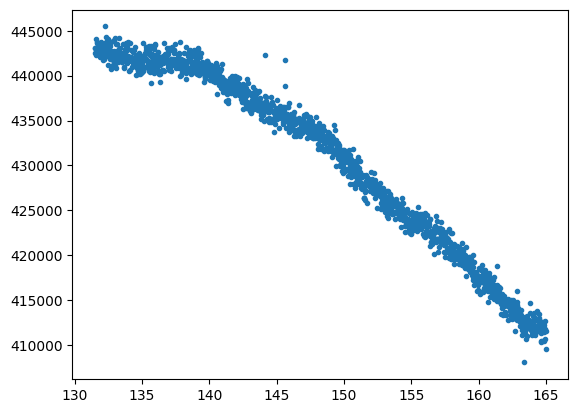

In [96]:
plt.plot(df['TIME'], df['FLUX'], '.')

In [97]:
t, flux, sigma_flux = df['TIME'].values, df['FLUX'].values/np.mean(df['FLUX']), np.ones_like(df['FLUX'].values)*8e-4

In [98]:
def bin_data(t, flux, err, binsize=30):
    # Make the size of the array divisible by binsize
    # so we can bin by simple array reshaping
    trim = len(t) % binsize
    t = t[:-trim]
    flux = flux[:-trim]

    # Bin the data
    t = t.reshape(-1, binsize).mean(axis=1)
    flux = flux.reshape(-1, binsize).mean(axis=1)

    # Remove any nans
    idx = np.isnan(flux)
    t = t[~idx]
    flux = flux[~idx]

    # Error arrays
    err = (err[-1] / np.sqrt(binsize)) * np.ones_like(t)

    # Sort the arrays
    idx = np.argsort(t)
    t = t[idx]
    flux = flux[idx]
    err = err[idx]

    return t, flux, err

In [99]:
t_, flux_, ferr_ = bin_data(t, flux, sigma_flux)

In [101]:
star_name = "KIC "+kic_ids[1]

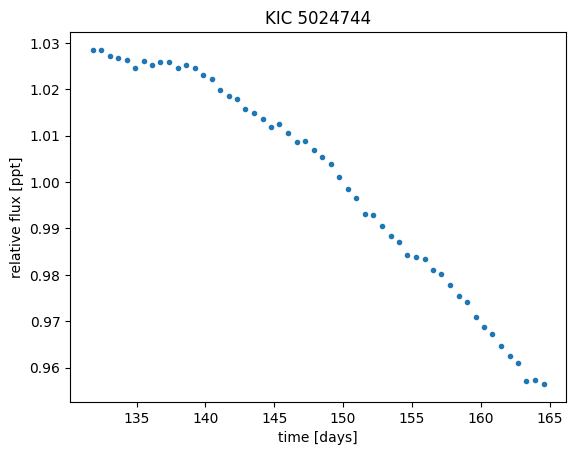

In [102]:
plt.errorbar(t_, flux_, yerr=ferr_, fmt='.')
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title(f"{star_name}")

In [103]:
np.sum(np.isnan(flux_))

0

Text(0, 0.5, 'Power')

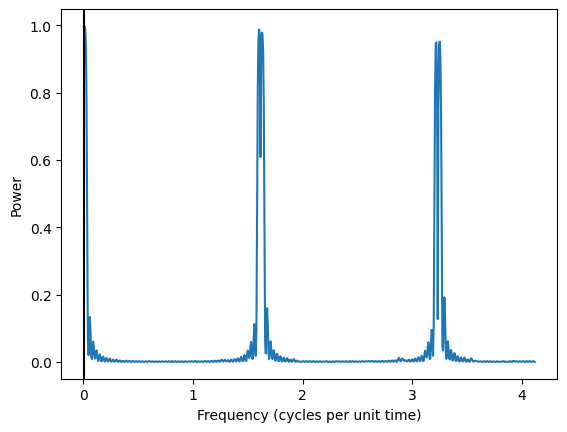

In [104]:
import nifty_ls
from astropy.timeseries import LombScargle

frequency, power = LombScargle(t_, flux_).autopower(method='fastnifty')
plt.plot(frequency, power)
peak = frequency[np.where(power==np.max(power))[0][0]]
plt.axvline(peak, color='black')
plt.xlabel('Frequency (cycles per unit time)')
plt.ylabel('Power')

In [105]:
peak_period=1/peak

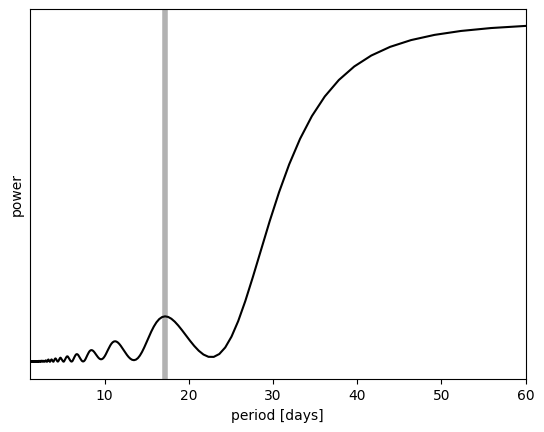

In [107]:
results = xo.estimators.lomb_scargle_estimator(
    t_, flux_, max_peaks=1, min_period=1.1, max_period=60.0, samples_per_peak=25
)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")

In [108]:
peak_period, peak['period']

(109.18824125876152, 17.207997737926874)

In [109]:
def gp_model(t, flux, ferr, peak_period):
    mean_flux = np.mean(flux)
    std_flux = np.std(flux)
    dt_median = np.median(np.diff(t))
    T = t[-1] - t[0]

    with pm.Model() as model:
        mean = pm.Normal("mean", mu=mean_flux, sigma=std_flux)

        sigma_rot1 = pm.Exponential("sigma_rot1", lam=1/std_flux)
        # log_period1 = pm.Uniform("log_period1", np.log(max(0.1,peak_period-2)), np.log(peak_period+1))
        log_period1 = pm.Normal("log_period1", mu=np.log(peak_period), sigma=0.01)
        period1 = pm.Deterministic("period1", pm.math.exp(log_period1))
        log_tau1 = pm.Uniform('log_tau1', np.log(period1), np.log(100*period1))
        tau1 = pm.Deterministic('tau1', pm.math.exp(log_tau1))

        sigma_rot2 = pm.Exponential("sigma_rot2", lam=1/std_flux)
        period2 = pm.Deterministic("period2", period1 / 2.0)
        log_tau2 = pm.Uniform('log_tau2', np.log(period2), np.log(100*period2))
        tau2 = pm.Deterministic('tau2', pm.math.exp(log_tau2))

        kernel1 = pm_terms.SHOTerm(sigma=sigma_rot1, tau=tau1, rho=period1)
        kernel2 = pm_terms.SHOTerm(sigma=sigma_rot2, tau=tau2, rho=period2)
        kernel = kernel1 + kernel2  

        gp = GaussianProcess(
            kernel,
            t=t,
            diag=ferr**2,
            mean=mean,
            quiet=True,
        )

        # Compute the Gaussian Process likelihood
        gp.marginal("gp", observed=flux)

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict(flux))

    return model

In [110]:
model = gp_model(t_, flux_, ferr_, peak['period'])

/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/pytensor/tensor/random/op.py:83: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/pytensor/tensor/random/op.py:93: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(


In [111]:
with model:
    map_soln = pm.find_MAP()

/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

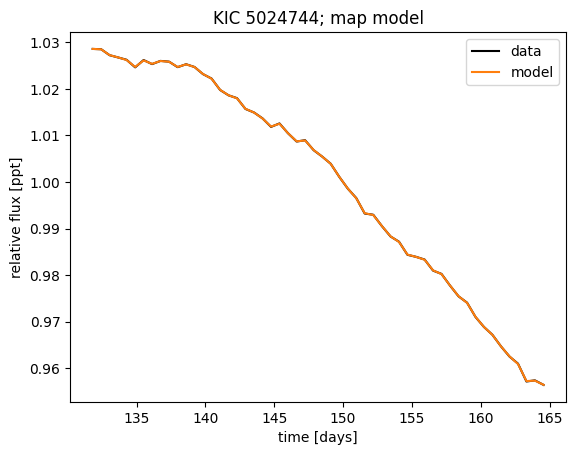

In [113]:
plt.plot(t_, flux_, "k", label="data")
plt.plot(t_, map_soln["pred"], color="C1", label="model")
# plt.xlim(t.min(), t[15000])
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title(f"{star_name}; map model")

In [114]:
map_soln['period1']

array(17.23748363)

In [115]:
peak['period']

17.207997737926874

In [116]:
with model:
    trace = pm.sample(
        tune=1000,
        draws=1000,
        start=map_soln,
        cores=4,
        chains=4,
        target_accept=0.9,
        return_inferencedata=True,
    )

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_64264/2393868277.py:2: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:735: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:735: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:735: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
/Users/sabina/miniconda3/envs/jax-env/lib/python3.12/site-packages/pytensor/tensor/elemwise.py:735: RuntimeWarning: inv

SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'mean': array(1.03820466), 'sigma_rot1_log__': array(-3.72207193), 'log_period1': array(3.05427849), 'log_tau1_interval__': array(nan), 'sigma_rot2_log__': array(-185.69020041), 'log_tau2_interval__': array(2.67174748)}

Logp initial evaluation results:
{'mean': 1.49, 'sigma_rot1': -1.0, 'log_period1': -214.52, 'log_tau1': nan, 'sigma_rot2': -181.92, 'log_tau2': -2.81, 'gp': -inf}
You can call `model.debug()` for more details.

In [ ]:
vars_names = ["log_period1",
        "tau1",
        "sigma_rot1",
        # "log_jitter",
        "mean",
        ]

array([[<Axes: title={'center': 'log_period1'}>,
        <Axes: title={'center': 'log_period1'}>],
       [<Axes: title={'center': 'tau1'}>,
        <Axes: title={'center': 'tau1'}>],
       [<Axes: title={'center': 'sigma_rot1'}>,
        <Axes: title={'center': 'sigma_rot1'}>],
       [<Axes: title={'center': 'mean'}>,
        <Axes: title={'center': 'mean'}>]], dtype=object)

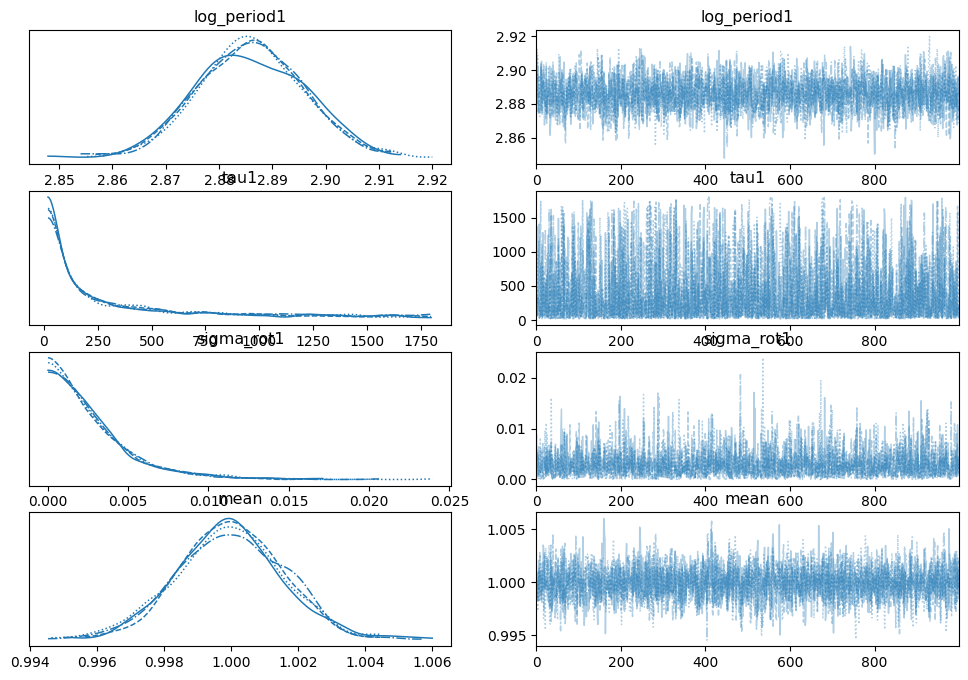

In [ ]:
import arviz as az
az.plot_trace(trace, var_names=vars_names)

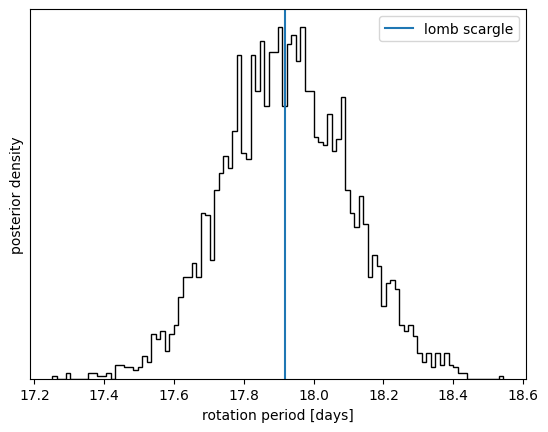

In [ ]:
period_samples = np.asarray(trace.posterior["period1"]).flatten()
plt.hist(period_samples, 100, histtype="step", color="k", density=True)
plt.axvline(peak['period'], label='lomb scargle')
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")
plt.legend()

/var/folders/6b/q0ls5s7570d8s04fbvw5gmxw0000gn/T/ipykernel_64264/580680865.py:47: UserWarning: Legend does not support handles for list instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  model_legend = ax[0].legend([model_plot1], ["GP Model"], fontsize=22, markerscale=3.0, loc="center",


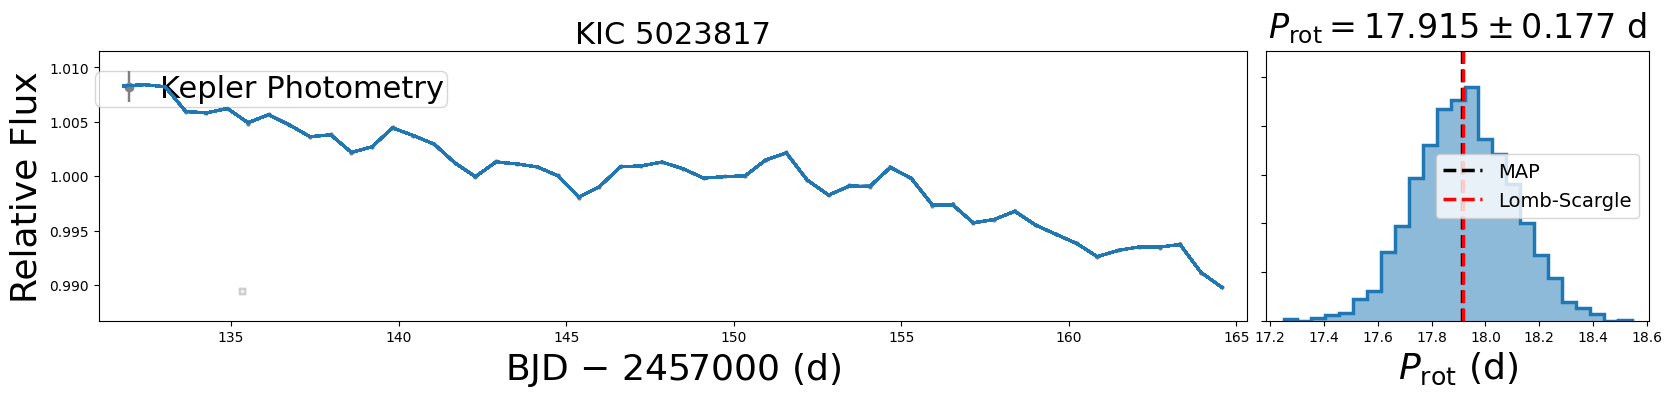

In [87]:
period_samples = np.asarray(trace.posterior["period1"]).flatten()
gridspec = {'hspace':0.35, 'wspace':0.025, 'width_ratios':[3.0, 1.0]}
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 3.5), gridspec_kw=gridspec)

data1 = ax[0].errorbar(x=t_, y=flux_, yerr=ferr_, ls='',
            markersize=2., elinewidth=1.75, barsabove=False, marker='o',
            markerfacecolor='grey', ecolor='grey', markeredgecolor='grey',
            rasterized=True, zorder=1)
for i in range(100):
    model_plot1 = ax[0].plot(t_, trace.posterior['pred'][random.randint(0,3)][random.randint(0,999)], color="C0", label="QP GP Model", lw=1.75, zorder=10)

ax[1].hist(period_samples, bins=25, histtype="stepfilled", color="C0", alpha=0.5)
ax[1].hist(period_samples, bins=25, histtype="step", color="C0", lw=2.5)

prot1_ax_lim = ax[1].get_ylim()
ax[1].set_ylim([prot1_ax_lim[0], prot1_ax_lim[-1]*1.1])

ax[1].axvline(map_soln['period1'], color='black', ls='--', lw=2.5, label='MAP')
ax[1].axvline(peak['period'], color='red', ls='--', lw=2.5, label='Lomb-Scargle')
# ax[1].axvline(santos, color='purple', ls='--', lw=2.5, label='Santos 2021')

ax[1].set_title(r"$P_\mathrm{{rot}} = {0:.3f} \pm {1:.3f}$ d".format(map_soln['period1'], np.std(period_samples, ddof=1)), color="black", fontsize=24, pad=10)

ax[1].tick_params(labelleft=False)

ax[0].set_xlim(t_.min()-0.75, t_.max()+0.75)

ax[0].set_title(f"{star_name}", fontsize=22)

current_ylim = ax[0].get_ylim()

ax[0].set_ylim([0.998*current_ylim[0], 1.002*current_ylim[-1]])

ax[0].set_xlabel("BJD $-$ 2457000 (d)", fontsize=26)
ax[0].set_ylabel("Relative Flux", fontsize=26)

ax[1].set_xlabel(r"$P_\mathrm{rot}$ (d)", fontsize=26)

ax[0].legend(fontsize=18, markerscale=3.0, handletextpad=0.4)
ax[1].legend(fontsize=14)

data_legend = ax[0].legend([data1], ["Kepler Photometry"], fontsize=22,
                            markerscale=3.0, loc="center", handletextpad=0.005, labelspacing=0.1,
                            borderaxespad=0.1, borderpad=0.1,
                            bbox_transform=ax[0].transAxes, bbox_to_anchor=(0.15, 0.86))

model_legend = ax[0].legend([model_plot1], ["GP Model"], fontsize=22, markerscale=3.0, loc="center",
                            handletextpad=0.5, labelspacing=0.2,
                            borderaxespad=0.1, borderpad=0.1,
                            bbox_transform=ax[0].transAxes, bbox_to_anchor=(0.125, 0.11))

ax[0].add_artist(data_legend)
ax[0].add_artist(model_legend)

# plt.savefig(f'{star_name}.pdf', dpi=300)

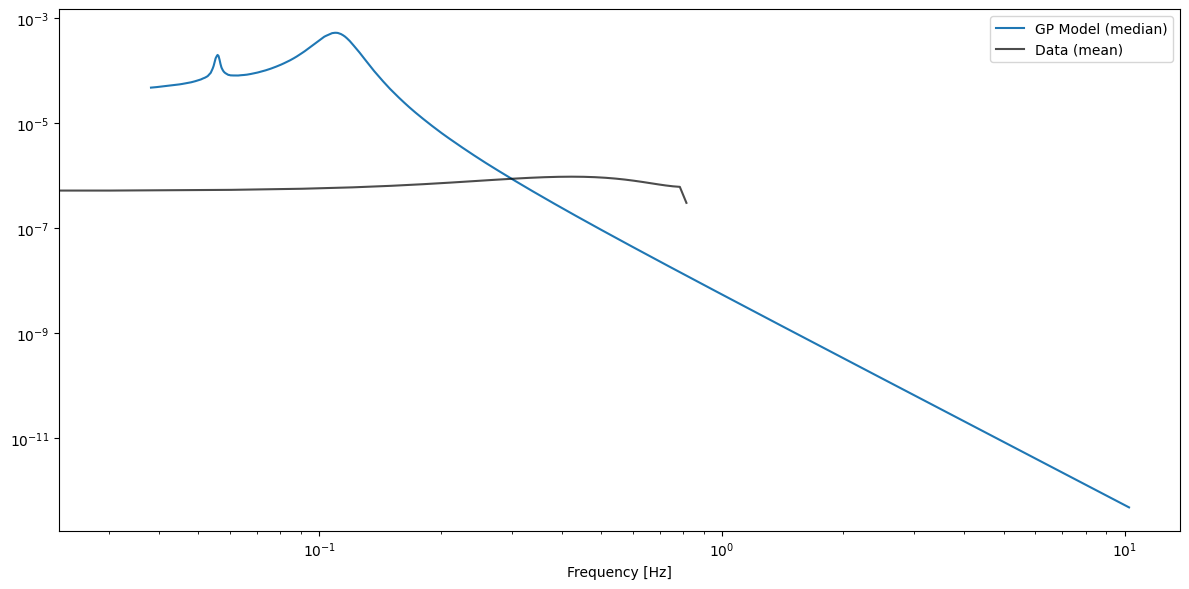

In [91]:
from scipy import signal
def get_model_power_spectrum(t, trace, samples=1000):
    freq = np.logspace(np.log10(2*np.pi/t.max()), np.log10(2*np.pi/np.min(np.diff(t))), 1000)
    power_spectra = np.zeros((samples, len(freq)))
    
    for i in range(samples):
        idx = np.random.randint(len(trace.posterior["sigma_rot1"].values.flatten()))
        
        kernel1 = terms.SHOTerm(
            sigma=float(trace.posterior["sigma_rot1"].values.flatten()[idx]),
            tau=float(trace.posterior["tau1"].values.flatten()[idx]),
            rho=float(trace.posterior["period1"].values.flatten()[idx])
        )
        kernel2 = terms.SHOTerm(
            sigma=float(trace.posterior["sigma_rot2"].values.flatten()[idx]),
            tau=float(trace.posterior["tau2"].values.flatten()[idx]),
            rho=float(trace.posterior["period2"].values.flatten()[idx])
        )
        kernel = kernel1 + kernel2
        power_spectra[i] = kernel.get_psd(2*np.pi*freq)
    
    return freq, np.percentile(power_spectra, [16, 50, 84], axis=0)

time_days = t_ - t_[0]
segment_indices = []
current_idx = 0
segment_days = 2

min_segment_length = len(t_)
while current_idx < len(t_):
    segment_end = np.searchsorted(time_days[current_idx:], time_days[current_idx] + segment_days)
    if segment_end == 0:
        break
    segment_indices.append((current_idx, current_idx + segment_end))
    current_idx += segment_end

sampling_freq = 1.0 / np.median(np.diff(t_))
nperseg = min(min_segment_length, 128)  # reduced from 256 to ensure consistency
nfft = nperseg

# Pre-calculate frequency array
freqs = np.fft.rfftfreq(nfft, d=1/sampling_freq)

# Pre-allocate array for all PSDs
all_psds = np.zeros((len(segment_indices), len(freqs)))

# Calculate power spectrum for each segment
for i, (start_idx, end_idx) in enumerate(segment_indices):
    segment_flux = flux_[start_idx:end_idx]
    _, psd = signal.welch(segment_flux, fs=sampling_freq, window='hann', 
                         nperseg=nperseg, nfft=nfft)
    all_psds[i] = psd

# Calculate statistics
avg_psd = np.mean(all_psds, axis=0)
std_psd = np.std(all_psds, axis=0)

# Get model power spectrum
model_freq, model_psd = get_model_power_spectrum(t_, trace)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot model posterior
# ax.fill_between(model_freq, model_psd[0], model_psd[2], color='C0', alpha=0.3, label='GP Model (16-84th percentile)')
ax.plot(model_freq, model_psd[1], 'C0-', label='GP Model (median)')

ax.plot(freqs, avg_psd, 'k-', alpha=0.7, label='Data (mean)')
# ax.fill_between(freqs, avg_psd-std_psd, avg_psd+std_psd, color='k', alpha=0.2, label='Data (±1σ)')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Frequency [Hz]')
ax.legend()

plt.tight_layout()
plt.show()

In [92]:
len(all_psds[1])

28